## packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Read grid and masks

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [11]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

In [12]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


### Get timesteps

In [13]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(12,13,1)
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

### mass tendency

In [14]:
# ocean and ice
AB_gT=0
AB_gS=0
debug = False

In [15]:
# ffac = 1e-6
ffac = 1

In [16]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx)) * wetmask[0,:,:]

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [17]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [18]:
# do volume and mass tendency
voltend = vol[1,:,:,:] - vol[0,:,:,:]         # m^3/month
voltend = voltend/int(dt)                          # m^3/s
tmptend = voltend * myparms["rhoconst"]    # kg/s

In [19]:
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN','SIheff','SIhsnow'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
tend = np.zeros((len(tsstr)-1,nz, ny, nx))
print(tend.shape)

for t in range(len(tsstr)-1):
    print(t)
    t1 = tsstr[t]
    t2 = tsstr[t+1]
    read = [int(t1),int(t2)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    SIheff,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])
    SIhsnow,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[2])

    # do differencing
    dETAN_dt =  (ETAN[1, :, :] - ETAN[0, :, :]) / dt  # change naming to dEtan_dt  m/s
    dSIheff_dt =  (SIheff[1, :, :] - SIheff[0, :, :]) / dt
    dSIhsnow_dt = (SIhsnow[1, :, :] - SIhsnow[0, :, :]) / dt

    # choose by basin
    # select by existing basin in mskBasin
    dETAN_dt = np.reshape(dETAN_dt,(ny,nx)) #* mymsk
    dSIheff_dt = np.reshape(dSIheff_dt,(ny,nx)) #* mymsk
    dSIhsnow_dt = np.reshape(dSIhsnow_dt,(ny,nx)) #* mymsk

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmptend = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmptend[0,:, :] = dETAN_dt * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmptend[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC
            tmp2 = tmp1/mk3D_mod(DD,tmp1)
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)
            
        tmptend = tmp2 * mk3D_mod(dETAN_dt, tmp2) * myparms['rhoconst'] * mk3D_mod(RAC, hfC)    # kg/s

    tend[t,:,:,:] = tmptend

(1, 50, 1350, 270)
0


In [20]:
tend = tend[0]
# tend = get_aste_tracer(tend,nfx,nfy)
tend.shape

(50, 1350, 270)

In [21]:
# this is wrong rewrite
# An has written nansum(tmptend, axis=3) but this is her z axis; I think we want axis = 0
budgO = {'fluxes': {'tend': tend}}
budgO['tend'] = np.nansum(tend,axis=0)

### Calculate horizontal convergence

In [22]:
# read U and V mass
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m/s
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m/s

# read advective
meta_budg2d_hflux_set1= parsemeta(dirIn + "budg2d_hflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_hflux_set1['fldList'])
varnames = np.array(['ADVxHEFF','ADVyHEFF','ADVxSNOW','ADVySNOW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m.m^2/s    ice 
ADVyHEFF,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m.m^2/s    ice 
ADVxSNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[2])       # m.m^2/s    snow
ADVySNOW,its,meta = rdmds(dirIn + "budg2d_hflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[3])

In [23]:
UVELMASS = UVELMASS.reshape(nz,ny,nx) #* wetmask[:,:,:] * mymsk[np.newaxis,:,:]
VVELMASS = VVELMASS.reshape(nz,ny,nx) #* wetmask[:,:,:] * mymsk[np.newaxis,:,:]
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVyHEFF.reshape(ny,nx)
ADVxSNOW = ADVxSNOW.reshape(ny,nx)
ADVySNOW = ADVySNOW.reshape(ny,nx)

In [24]:
# THERE IS NO DFXEHEFF OR DFYEHEFF! This has not been handled in this notebook
# Calculations for ocean
tmpUo = myparms['rhoconst'] * dyg3d * drf3d * UVELMASS   # kg/s
tmpVo = myparms['rhoconst'] * dxg3d * drf3d * VVELMASS   # kg/s
tmpUo_tracer = get_aste_tracer(tmpUo,nfx,nfy)
tmpVo_tracer = get_aste_tracer(tmpVo,nfx,nfy)

In [25]:
budgO['fluxes']['hconv'] = calc_UV_conv_1face(tmpUo, tmpVo)
budgO['hconv'] = calc_UV_conv_1face(np.nansum(tmpUo, axis=0), np.nansum(tmpVo, axis=0))

In [26]:
# budgO['fluxes']['hconv'] = aste_tracer2compact(calc_UV_conv_1face(tmpUo_tracer, tmpVo_tracer),nfx,nfy)
# budgO['hconv'] = aste_tracer2compact(calc_UV_conv_1face(np.nansum(tmpUo_tracer, axis=0), np.nansum(tmpVo_tracer, axis=0)),nfx,nfy)

### Calculate vertical convergence

In [27]:
# rewrite with only reading in these lines, be sure to compare
meta_budg2d_zflux_set1= parsemeta(dirIn + "budg2d_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg2d_zflux_set1['fldList'])
varnames = np.array(['oceFWflx','SIatmFW'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
oceFWflx,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])
# Net freshwater flux from atmosphere & land (+=down)
SIatmFW,its,meta = rdmds(dirIn + "budg2d_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])

# read WVELMASS
meta_budg3d_zflux_set2= parsemeta(dirIn + "budg3d_zflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_zflux_set2['fldList'])
varnames = np.array(['WVELMASS'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
# Vertical Mass-Weighted Comp of Velocity
WVELMASS,its,meta = rdmds(dirIn + "budg3d_zflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])

In [28]:
# oceFWflx = oceFWflx.reshape(ny,nx)
# iy = 437
# ix = 220
# print(oceFWflx[iy,ix])
# WVELMASS = WVELMASS.reshape(nz,ny,nx)
# print(WVELMASS[:,iy,ix])
# print(trWtop[:,iy,ix])
# print(budgO["fluxes"]["trWtop"][:,iy,ix])
# print(budgO["fluxes"]["trWbot"][:,iy,ix])

In [29]:
oceFWflx = oceFWflx.reshape(ny,nx)  # * wetmask[0,:,:] * mymsk                       # kg/m^2/s
# SIatmFW = SIatmFW.reshape(ny,nx) * wetmask[0,:,:] * mymsk                         # kg/m^2/s
WVELMASS = WVELMASS.reshape(nz,ny,nx)

In [30]:
# Perform calculations
budgO["zconv"] = oceFWflx

if not myparms["useRFWF"]:
    budgO["zconv"] = 0 * budgO["zconv"]

trWtop = -WVELMASS * myparms["rhoconst"]
print(trWtop.shape)

# indexing seems fishy here - rewrite
if myparms["useNLFS"] < 2 or myparms["rStar"] == 0:
    trWtop[0, :, :] = oceFWflx
    if not myparms["useRFWF"]:
        trWtop[0,:, :] = -WVELMASS[0,:, :] * myparms["rhoconst"]

# same size trWtop and TrWbot
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:, :] = trWtop[1:,:, :]

#budgO["fluxes"] = {}
budgO["fluxes"]["trWtop"] = trWtop * RAC3
budgO["fluxes"]["trWbot"] = trWbot * RAC3
budgO["fluxes"]["zconv"] = budgO["fluxes"]["trWtop"] - budgO["fluxes"]["trWbot"]

# changed axis here to 0 because we're looking at z
if myparms["useNLFS"] < 2 or (myparms["rStar"] == 0 and not myparms["useRFWF"]):
    budgO["zconv"] += np.sum(trWtop - trWbot, axis=0)

budgO["zconv"] = RAC * budgO["zconv"]

(50, 1350, 270)


In [31]:
budgO['hconv'].shape

(1, 1350, 270)

In [32]:
budgO['hconv'].shape

(1, 1350, 270)

### Is this budgeted in horizontal space?

In [33]:
for i,j in zip(np.where(mskBasin == iB)[0],np.where(mskBasin == iB)[1]):
    print(i,j)

434 162
434 163
434 246
434 247
435 162
435 163
435 245
435 246
435 247
435 248
436 162
436 163
436 164
436 243
436 244
436 245
436 246
436 247
436 248
436 249
437 162
437 163
437 164
437 220
437 221
437 222
437 223
437 224
437 225
437 243
437 244
437 245
437 246
437 247
437 248
437 249
438 162
438 163
438 164
438 218
438 219
438 220
438 221
438 222
438 223
438 224
438 225
438 226
438 227
438 228
438 229
438 230
438 243
438 244
438 245
438 246
438 247
438 248
438 249
439 162
439 163
439 164
439 165
439 166
439 167
439 168
439 169
439 216
439 217
439 218
439 219
439 220
439 221
439 222
439 223
439 224
439 225
439 226
439 227
439 228
439 229
439 230
439 243
439 244
439 245
439 246
439 247
439 248
439 249
440 162
440 163
440 164
440 165
440 166
440 167
440 168
440 169
440 170
440 171
440 213
440 214
440 215
440 216
440 217
440 218
440 219
440 220
440 221
440 222
440 223
440 224
440 225
440 226
440 227
440 228
440 229
440 230
440 244
440 245
440 246
440 247
440 248
440 249
441 162
441 163


In [34]:
# pt = np.array([[165,442,4],
#                [210,442,10]])

pt = np.array([[165,442,4],
               [210,442,10],
               [56,533,13],
               [53,561,13]])

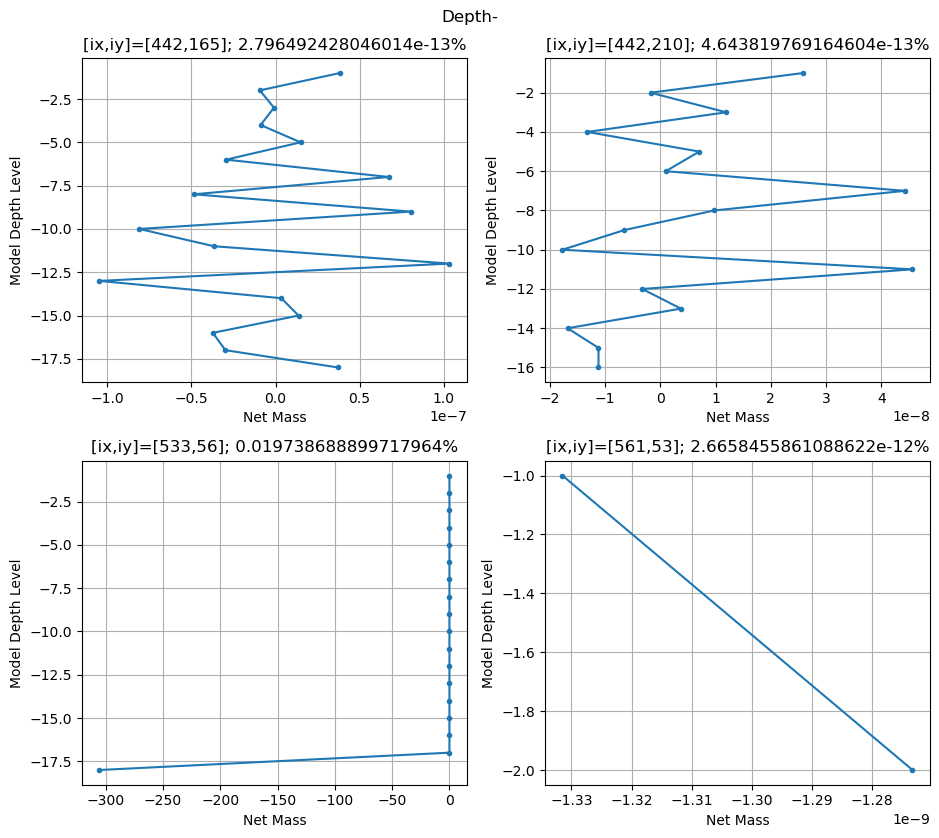

In [35]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 5):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Mass")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

In [36]:
mymsk3 = mymsk.copy()
mymsk3[:,151:] = np.nan
# plt.pcolormesh(b[0]*mymsk3)

In [90]:
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)

In [91]:
budgO['fluxes']['tend'].shape

(50, 1350, 270)

In [92]:
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

In [93]:
mymsk2.shape

(1, 900, 540)

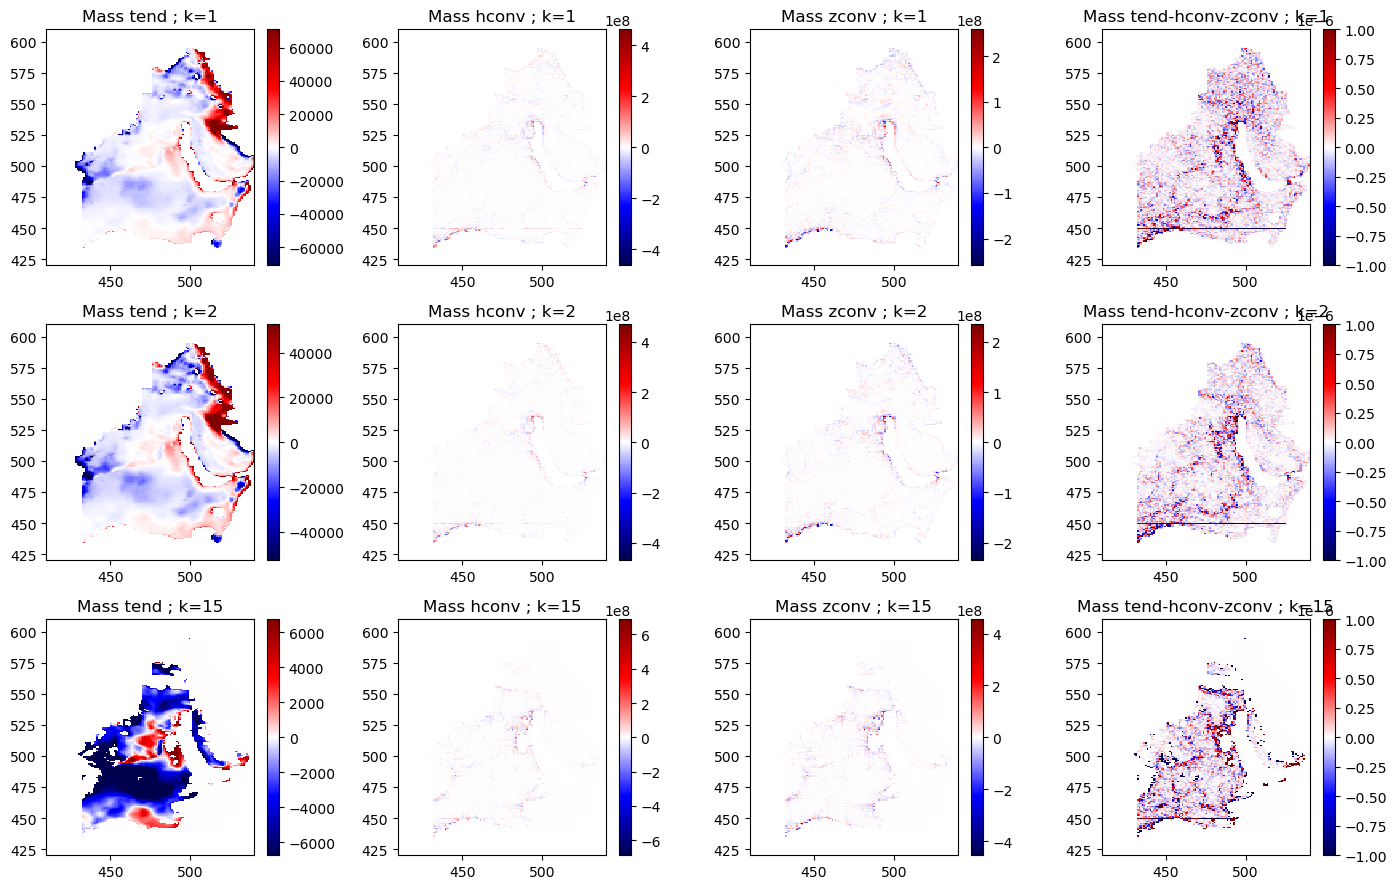

In [94]:
# Figure 2


klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    fourth = 1
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        mydata = get_aste_tracer(data[k1-1,:, :],nfx,nfy)[0]
        #mydata = data[k1-1,:, :]
        if fourth == 4:
            pcm = ax.pcolormesh(mydata*mymsk2[0], cmap='seismic', vmin=-1e-6, vmax=1e-6)
        else:
            pcm = ax.pcolormesh(mydata*mymsk2[0], cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)

        #ax.scatter(get_aste_tracer(np.array([[533],[56]]),nfx,nfy)[0])
    
        ax.set_title(f"{strbudg} {title} {str_k}")
        ax.set_xlim(410,540)
        ax.set_ylim(420,610)

        fourth += 1

plt.tight_layout()
# plt.savefig(f"{dirOut}{strbudg}_budget2_{t2:010}.png")
plt.show()

### Binning - we can try and bin our oce tend/hconv/zconv by TS

In [42]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

In [43]:
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

In [44]:
# read in the initial model T-S fields
# create an array to store the values at all time steps
fileTS = np.zeros((len(tsstr),2,nz,ny,nx))
print(fileTS.shape)

# read each of the files from the list
for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = int(t1)

    # read the file
    thisfileTS = rdmds(dirIn + "budg3d_snap_set2",read)    # dr values, z, y, x
    thisfldListTS = parsemeta(dirIn + "budg3d_snap_set2." + tsstr[t] + ".meta")["fldList"]
    
    thisfileTS = thisfileTS.reshape(2,nz, ny, nx)

    fileTS[t,:,:,:,:] = thisfileTS

# we should unweight these before we add them to the dataset
DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))
temp = fileTS[:,0,:,:,:] / DRF3d
salt = fileTS[:,1,:,:,:] / DRF3d

(2, 2, 50, 1350, 270)


In [45]:
ds = xr.Dataset()
dims = ("iteration","z","compact_x","compact_y")

coords = {"iteration":datetimes,
          "z": np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

ds["theta"] = xr.DataArray(data = temp,dims=dims,coords=coords)
ds["salinity"] = xr.DataArray(data = salt,dims=dims,coords=coords)

In [46]:
# create this as an xarray and add it to the dataset
# now the bins should go up to 112
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

binned_theta.shape

ds["theta_binned"] = xr.DataArray(data = binned_theta * wetmask[np.newaxis,:,:,:],
                    dims = dims,
                    coords = coords)

ds["salinity_binned"] = xr.DataArray(data = binned_salinity * wetmask[np.newaxis,:,:,:],
                    dims = dims,
                    coords = coords)

In [47]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

### Add the volume budgeting from xyz

In [48]:
# remember we should be masking at the end to make sure this works at basin edges
# we have the budgO, we should be able to bin this in TS space
fluxes_tend = xr.DataArray(data = budgO['fluxes']['tend'],
                    dims = dims[1:],
                    coords = [coords["z"],coords["compact_x"],coords["compact_y"]],
                    attrs = {'title' : 'gridded xyz mass tendency',
                             'units' : 'kg/s'})

tend = xr.DataArray(data = budgO['tend'],
                    dims = dims[2:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = {'title' : 'gridded xyz mass tendency',
                             'units' : 'kg/s'})

fluxes_hconv = xr.DataArray(data = budgO['fluxes']['hconv'],
                    dims = dims[1:],
                    coords = [coords["z"],coords["compact_x"],coords["compact_y"]],
                    attrs = {'title' : 'gridded xyz mass horizontal convergence',
                             'units' : 'kg/s'})

hconv = xr.DataArray(data = budgO['hconv'][0],
                    dims = dims[2:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = {'title' : 'gridded xyz mass horizontal convergence',
                             'units' : 'kg/s'})

fluxes_zconv = xr.DataArray(data = budgO['fluxes']['zconv'],
                    dims = dims[1:],
                    coords = [coords["z"],coords["compact_x"],coords["compact_y"]],
                    attrs = {'title' : 'gridded xyz mass vertical convergence',
                             'units' : 'kg/s'})

zconv = xr.DataArray(data = budgO['zconv'],
                    dims = dims[2:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = {'title' : 'gridded xyz mass vertical convergence',
                             'units' : 'kg/s'})

ds['tend'],ds['fluxes_tend']   = tend,fluxes_tend
ds['hconv'],ds['fluxes_hconv'] = hconv,fluxes_hconv
ds['zconv'],ds['fluxes_zconv'] = zconv,fluxes_zconv

In [80]:
fluxes_tend_mesh = create_mesh(1,ds,nS,nT,npoints,"fluxes_tend",mskBasin,iB,dT,dS)
fluxes_hconv_mesh = create_mesh(1,ds,nS,nT,npoints,"fluxes_hconv",mskBasin,iB,dT,dS)
fluxes_zconv_mesh = create_mesh(1,ds,nS,nT,npoints,"fluxes_zconv",mskBasin,iB,dT,dS)

In [81]:
test = np.where(mskBasin == iB)
idcs = np.where(test[1]<150)
idcs[0].shape

(9940,)

In [82]:
fluxes_tend_mesh = np.nansum(fluxes_tend_mesh[0][:,:,idcs[0]],axis=2)
fluxes_hconv_mesh = np.nansum(fluxes_hconv_mesh[0][:,:,idcs[0]],axis=2)
fluxes_zconv_mesh = np.nansum(fluxes_zconv_mesh[0][:,:,idcs[0]],axis=2)

### Try plotting

In [83]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',21).copy()
cmap.set_under(color='white')

In [84]:
# make density contours lines function
# add the polygons and the points
smin = 25 - (0.01 * 25)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2.5 + (0.1 * -2.5)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 10 + (0.1 * 10)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2.5,10,ydim)
si = np.linspace(25,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

# convert to practical/potential if needed
# long = 73.5089
# lat = -66.8245
# ti = gsw.pt_from_CT(si1,ti1)
# si = gsw.SP_from_SA(si1,0,long,lat)

tmin, tmax, smin, smax sizes=, -2.75 11.0 24.75 38.38


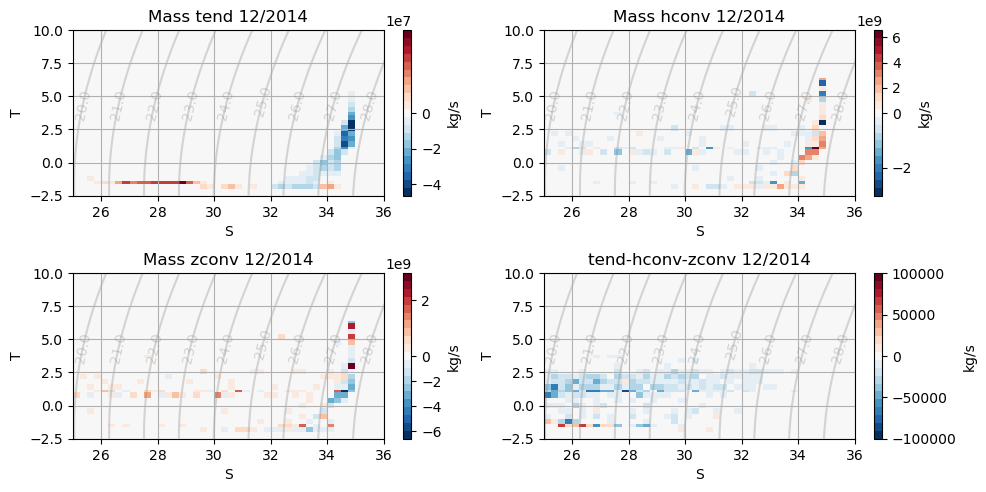

In [89]:
#this does not make sense to plot
# plot and try to understand surface flux
# this is only at the surface!

fig = plt.figure(figsize=(10,5))

cmap = plt.get_cmap('RdBu_r',21).copy()
cmap.set_under(color='white')

ax = plt.subplot(221)
norm = TwoSlopeNorm(vcenter=0)
cb = ax.pcolormesh(Sbin,Tbin,fluxes_tend_mesh, norm=norm, cmap=cmap)
# # add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label=ds.fluxes_tend.attrs["units"])
ax.set_title("Mass tend 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

ax = plt.subplot(222)
norm = TwoSlopeNorm(vcenter=0)
cb = ax.pcolormesh(Sbin,Tbin,fluxes_hconv_mesh, norm=norm, cmap=cmap)
# # add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label=ds.fluxes_hconv.attrs["units"])
ax.set_title("Mass hconv 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

ax = plt.subplot(223)
norm = TwoSlopeNorm(vcenter=0)
cb = ax.pcolormesh(Sbin,Tbin,fluxes_zconv_mesh, norm=norm, cmap=cmap)
# # add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label=ds.fluxes_zconv.attrs["units"])
ax.set_title("Mass zconv 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)


ax = plt.subplot(224)
norm = TwoSlopeNorm(vmin=-1e5,vcenter=0,vmax=1e5)
cb = ax.pcolormesh(Sbin,Tbin,fluxes_tend_mesh - fluxes_zconv_mesh - fluxes_hconv_mesh, norm=norm, cmap=cmap)
# # add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label=ds.fluxes_zconv.attrs["units"])
ax.set_title("tend-hconv-zconv 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

fig.tight_layout(pad=1.0)